<a href="https://colab.research.google.com/github/hpazerf/instagram-topic_modeling/blob/main/Instagram_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install instaloader
!pip install --upgrade google-cloud-vision

## Importing Libraries

In [ ]:
import instaloader
from google.cloud import vision

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

## Instagram Scraper

In [ ]:
#initializing the scraper and seting the user name as 'natgeo' to look at national geographic instagram account 
L = instaloader.Instaloader()
username = 'natgeo'
profile = instaloader.Profile.from_username(L.context, username)

# get the posts from the username
posts = profile.get_posts()

In [ ]:
# Creating the dataframe to place the information into
instagram_posts = pd.DataFrame(columns=['post_url', 'comment_num', 'like_num', 'post_caption', 'image_url'])


# Creating the url by collecting the shortcode and combining with this url string
post_url = 'https://www.instagram.com/p/{}/'

# Initializing i
i = 0
for post in posts:
    if i < 500:
        if post.is_video == False:
          i += 1  
          # Add the information to the dataframe created before
          instagram_posts = instagram_posts.append({'post_url': post_url.format(post.shortcode),
                                                    'comment_num': post.comments,
                                                    'like_num': post.likes,
                                                    'post_caption': post.caption,
                                                    'image_url': post.url}, ignore_index=True)
    else:
        break

In [ ]:
instagram_posts.head()

,post_url,comment_num,like_num,post_caption,image_url
0,https://www.instagram.com/p/CHYOgoNLjwD/,157,24098,Photo by @erintrieb / On Election Day I set up...,https://scontent-iad3-1.cdninstagram.com/v/t51...
1,https://www.instagram.com/p/CHXl8P8gT0f/,455,83621,Photo by @tasneemalsultan / A Saudi woman sits...,https://scontent-iad3-1.cdninstagram.com/v/t51...
2,https://www.instagram.com/p/CHXXmNpAhHV/,431,184808,Photo by Keith Ladzinski @ladzinski / A kiss o...,https://scontent-iad3-1.cdninstagram.com/v/t51...
3,https://www.instagram.com/p/CHXKiRnAshz/,511,106213,Photo by @dina_litovsky / Most people don’t as...,https://scontent-iad3-1.cdninstagram.com/v/t51...
4,https://www.instagram.com/p/CHWudbnoMhb/,554,162146,Photo by @paoloverzone / Fluorescing a ghostly...,https://scontent-iad3-1.cdninstagram.com/v/t51...


In [ ]:
instagram_posts.to_csv("instagram_posts.csv")

## Google Vision

In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= ""

def labelAnnotation(url):
  # Imports the Google Cloud client library
  from google.cloud import vision
  #from google.cloud.vision import types
  # Instantiates a client
  client = vision.ImageAnnotatorClient()

  response = client.annotate_image({
     'image': {'source': 
               {'image_uri': url}
              },
  })

  # Detect and Print Labels:
  label_list=[]
  labels = response.label_annotations
  for label in labels:
    label_list.append(label.description)
  return label_list

In [ ]:
instagram_posts['labels'] = instagram_posts['image_url'].apply(labelAnnotation)

In [ ]:
instagram_posts.to_csv("instagram_posts_labeled.csv")

## Task A: Engagement Metric

In [ ]:
ig_post_labeled = pd.read_csv("instagram_posts_labeled.csv", index_col=0)

In [ ]:
# Normalizing the like and comment values
ig_post_labeled['like_percent'] = (ig_post_labeled['like_num'] / ig_post_labeled.like_num.max())
ig_post_labeled['comment_percent'] = (ig_post_labeled['comment_num'] / ig_post_labeled.comment_num.max())

# Calculating the engagement score using specific weights for the likes and the comments
like_weight = 0.4
comment_weight = 0.6
ig_post_labeled['engagement_score'] = ig_post_labeled['like_percent']*like_weight + ig_post_labeled['comment_percent']*comment_weight

# Classifying the engagment score as High (1) or Low(0) based on the median value
ig_post_labeled['engagement_binary_class'] = np.where(ig_post_labeled['engagement_score'] >= np.median(ig_post_labeled.engagement_score), 1, 0)

In [ ]:
ig_post_labeled.sort_values(by=['engagement_score']).head(3)

,post_url,comment_num,like_num,post_caption,image_url,labels,like_percent,comment_percent,engagement_score,engagement_binary_class
0,https://www.instagram.com/p/CHYOgoNLjwD/,157,24098,Photo by @erintrieb / On Election Day I set up...,https://scontent-iad3-1.cdninstagram.com/v/t51...,"['Hair', 'Face', 'White', 'Black', 'Hairstyle'...",0.014033,0.003340,0.007617,0
39,https://www.instagram.com/p/CHJKjx4llu1/,215,77932,Photo by @andreabruce / Poll workers Tom Shank...,https://scontent-iad3-1.cdninstagram.com/v/t51...,"['Table', 'Design', 'Organism', 'Room', 'Event...",0.045382,0.004573,0.020897,0
125,https://www.instagram.com/p/CGk4iNtFt17/,174,89882,Ode to Michigan by James Earl Jones / For many...,https://scontent-iad3-1.cdninstagram.com/v/t51...,"['Advertising', 'Mural', 'Poster', 'Font', 'Ba...",0.052341,0.003701,0.023157,0


In [ ]:
ig_post_labeled.sort_values(by=['engagement_score'], ascending=False).head(3)

,post_url,comment_num,like_num,post_caption,image_url,labels,like_percent,comment_percent,engagement_score,engagement_binary_class
117,https://www.instagram.com/p/CGmxGAdM8vA/,47012,371803,Photo by Anastasia Taylor-Lind @anastasiatl / ...,https://scontent-iad3-1.cdninstagram.com/v/t51...,"['Landmark', 'Medieval architecture', 'Archite...",0.216513,1.000000,0.686605,1
23,https://www.instagram.com/p/CHQ-tOlDgpV/,8087,1717229,Photo by @bertiegregory / How many fish can a ...,https://scontent-iad3-1.cdninstagram.com/v/t51...,"['Beak', 'Fish', 'Bird']",1.000000,0.172020,0.503212,1
12,https://www.instagram.com/p/CHUyzWrAmaU/,23345,487668,Photo by Anastasia Taylor-Lind @anastasiatl / ...,https://scontent-iad3-1.cdninstagram.com/v/t51...,"['Bride', 'Photograph', 'Wedding dress', 'Dres...",0.283985,0.496575,0.411539,1


## Task B: Logistic Regression

### Word Replacement

In [ ]:
instagram_posts = pd.read_csv('instagram_posts_labeled.csv', index_col=0)

In [ ]:
instagram_posts.loc[0,'labels']

"['Hair', 'Face', 'White', 'Black', 'Hairstyle', 'Shoulder', 'Head', 'Eyebrow', 'Black-and-white', 'T-shirt']"

In [ ]:
labels_df = ig_post_labeled.loc[:,['labels','engagement_binary_class']]

In [ ]:
replace_chars = "',[]" # initializing replacement characters (otherwise the labels show as strings)

documents = []
for i in range((labels_df.shape[0])):
    labels =  labels_df.loc[i,'labels'].split()
    for label in labels:
        for char in replace_chars:
            label = label.replace(char,'') # remove the excess characters
        content = label.lower() # make it lowercase
        documents.append(content) # add it to the document array
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
label_tfidf_df = pd.DataFrame(denselist, columns=feature_names).sum(axis=0).sort_values(ascending=False)
label_tfidf_df.to_csv("label_tfidf.csv")
label_tfidf_df.head(5)

sky            142.0
photography    125.0
tree            80.0
plant           72.0
water           71.0
dtype: float64

In [ ]:
df = pd.read_csv("label_tfidf.csv", header=0, names=['label','tfidf'])
df = df[df.tfidf > 5] # using 5 as a threshold for significant tfidf scores

label_list = []
for index, rows in df.iterrows():  
    label_list.append(str(rows.values[0])) # creating a list of all the labels
    ## may current repeat labels-- might need to look into changing that

# for each label in the label list, create a column in the dataframe for that label
# this allows us to use them all as independent variables for the logistic regression
for label in label_list:
    labels_df[label] = 0 # initializing the columns with all 0s
labels_df.head()

,labels,engagement_binary_class,sky,photography,tree,plant,water,phenomenon,landscape,natural,mountain,wildlife,cloud,nature,event,people,vehicle,animal,night,sea,adaptation,geological,monochrome,architecture,rock,black,terrestrial,mammal,recreation,white,and,area,environment,grass,fun,street,bird,landforms,human,art,...,morning,uniform,freezing,boat,flame,games,sports,sport,accessory,biome,fox,big,oceanic,ridge,coastal,glacier,dress,beauty,bed,coral,tiger,aeolian,badlands,steppe,botany,metropolitan,lion,standing,herd,festival,pasture,portrait,party,world,wing,hairstyle,motor,protest,sculpture,trail
0,"['Hair', 'Face', 'White', 'Black', 'Hairstyle'...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"['Room', 'Textile', 'Tradition', 'Bazaar', 'Fl...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"['Mountainous landforms', 'Mountain', 'Sky', '...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"['Motor vehicle', 'Vehicle', 'Mode of transpor...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"['Water', 'Blue', 'Liquid', 'Aqua', 'Transpare...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
index = 0
for label in labels_df['labels']: # for each row in the 'labels' column
    label = label.split(sep=None) # split the label string up into words
    for item in label: # for each of those words
        for char in replace_chars:
            item = item.replace(char,'') # remove the excess characters
        item = item.lower() # make it lowercase
        if item in label_list:
            labels_df[item][index] = 1 # set the value of that item to 1, in the corresponding row/column
    index = index + 1
labels_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,labels,engagement_binary_class,sky,photography,tree,plant,water,phenomenon,landscape,natural,mountain,wildlife,cloud,nature,event,people,vehicle,animal,night,sea,adaptation,geological,monochrome,architecture,rock,black,terrestrial,mammal,recreation,white,and,area,environment,grass,fun,street,bird,landforms,human,art,...,morning,uniform,freezing,boat,flame,games,sports,sport,accessory,biome,fox,big,oceanic,ridge,coastal,glacier,dress,beauty,bed,coral,tiger,aeolian,badlands,steppe,botany,metropolitan,lion,standing,herd,festival,pasture,portrait,party,world,wing,hairstyle,motor,protest,sculpture,trail
0,"['Hair', 'Face', 'White', 'Black', 'Hairstyle'...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,"['Room', 'Textile', 'Tradition', 'Bazaar', 'Fl...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"['Mountainous landforms', 'Mountain', 'Sky', '...",0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"['Motor vehicle', 'Vehicle', 'Mode of transpor...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,"['Water', 'Blue', 'Liquid', 'Aqua', 'Transpare...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# setting up logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import accuracy_score

X = labels_df.iloc[:, 2:].values
y = labels_df.iloc[:, 1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

lrmodel = LogisticRegression()
lrmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# using the model to predict the test data
y_pred = lrmodel.predict(X_test)

# printing misclassifications
print('Misclassified samples: %d' %(y_test != y_pred).sum())

# printing accuracy score
print('Accuracy: %.2f' % accuracy_score(y_test,y_pred))

Misclassified samples: 13
Accuracy: 0.74


In [ ]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


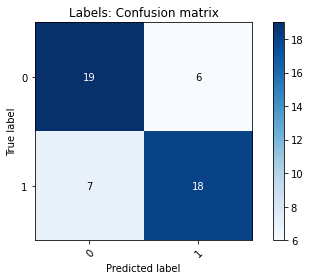

In [ ]:
plot_confusion_matrix(y_true = y_test, 
                      y_pred = y_pred, classes = np.unique(y_test),
                      title = 'Labels: Confusion matrix')

In [ ]:
# now doing same thing but for captions

In [ ]:
import inflect
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

p = inflect.engine()
stop_words=stopwords.words('english')

caption_replace = ig_post_labeled.loc[:,['post_caption','engagement_binary_class']]
replace_df = pd.read_csv('replacements.csv', header=None) # manually assigned word replacements

for i in range((replace_df.shape[0])-1):
    replacee=replace_df.loc[i,0]
    if isinstance(replace_df.loc[i,1],str) == True:
        replacedby=replace_df.loc[i,1]
        caption_replace["post_caption"]= caption_replace["post_caption"].str.replace(rf"\b{replacee}\b", replacedby, case = False)
        
documents = []
for i in range((caption_replace.shape[0])):
    content = caption_replace.loc[i,'post_caption'].lower()
    cleaned_content = [word for word in content.split() if not word in stop_words] # removed stopwords
    final_content = []
    for i in range (len(cleaned_content)):
        if p.singular_noun(cleaned_content[i]) is not False:
            cleaned_content[i] = p.singular_noun(cleaned_content[i]) # setting plurals to singular for accuracy
        word = nltk.pos_tag([cleaned_content[i]])[0]
        if word[1] in ['NN','VBG','VB','VBD','NNS','RB','POS','JJ','VBP']: # if word is a noun, verb, jerund
            final_content.append(word[0]) # add it in there
    documents += [' '.join(final_content)] ### this allows us to (hopefully) only include words that add value (like topics/labels)
    
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
cap_tfidf_df = pd.DataFrame(denselist, columns=feature_names).sum(axis=0).sort_values(ascending=False)
cap_tfidf_df.to_csv("cap_tfidf.csv")
cap_tfidf_df.head(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


person      18.193696
water       16.430825
photo       14.668865
landform    14.155695
flora       13.856893
dtype: float64

In [ ]:
df = pd.read_csv("cap_tfidf.csv", header=0, names=['capword','tfidf'])
df = df[df.tfidf > 5] # using 5 as a threshold for 'significant' tfidf

capword_list = []
for index, rows in df.iterrows():  
    capword_list.append(str(rows.values[0]))

captions_df = caption_replace.loc[:,['post_caption','engagement_binary_class']]
captions_df = caption_replace

for word in capword_list:
    captions_df[word] = 0 # initializing the columns with all 0s
captions_df.head()

,post_caption,engagement_binary_class,person,water,photo,landform,flora,color,fauna,sky,object,architecture,story,follow,world,year,new,see,image,nat,geo,check,day,link,bio,time,home,life,many,part,species,place,it,technology
0,Photo by @erintrieb / On Election Day I set up...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Photo by @tasneemalsultan / A Saudi woman sits...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Photo by Keith Ladzinski @ladzinski / A kiss o...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Photo by @dina_litovsky / Most people don’t as...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Photo by @paoloverzone / Fluorescing a ghostly...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
index = 0
for capword in captions_df['post_caption']: # for each row in the 'captions' column
    caption = capword.split(sep=None) # split the label string up into words
    for word in caption: # for each of those words
        for char in replace_chars:
            word = word.replace(char,'') # remove the excess characters
        word = word.lower() # make it lowercase
        if word in capword_list:
            captions_df[word][index] = 1 # set the value of that item to 1, in the corresponding row/column
    index = index + 1
captions_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,post_caption,engagement_binary_class,person,water,photo,landform,flora,color,fauna,sky,object,architecture,story,follow,world,year,new,see,image,nat,geo,check,day,link,bio,time,home,life,many,part,species,place,it,technology
0,Photo by @erintrieb / On Election Day I set up...,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,Photo by @tasneemalsultan / A Saudi woman sits...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Photo by Keith Ladzinski @ladzinski / A kiss o...,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Photo by @dina_litovsky / Most people don’t as...,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Photo by @paoloverzone / Fluorescing a ghostly...,0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0


In [ ]:
# setting up logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import accuracy_score

X = captions_df.iloc[:, 2:].values
y = captions_df.iloc[:, 1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

lrmodel = LogisticRegression()
lrmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# using the model to predict the test data
y_pred = lrmodel.predict(X_test)

# printing misclassifications
print('Misclassified samples: %d' %(y_test != y_pred).sum())

# printing accuracy score
print('Accuracy: %.2f' % accuracy_score(y_test,y_pred))

Misclassified samples: 17
Accuracy: 0.66


Confusion matrix, without normalization


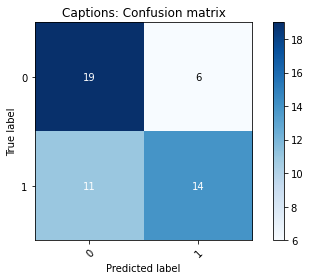

In [ ]:
plot_confusion_matrix(y_true = y_test, 
                      y_pred = y_pred, classes = np.unique(y_test),
                      title = 'Captions: Confusion matrix')

In [ ]:
### now the same thing but for captions + labels

In [ ]:
predictions_df = ig_post_labeled.loc[:,['post_caption','labels','engagement_binary_class']]
predictions_df['post_caption'] = caption_replace['post_caption']

word_list = []
for label in label_list:
    word_list.append(label)
    ''' maybe revise to:
        if label not in word_list:
          word_list.append(label)'''
for capword in capword_list:
    if capword not in word_list:
        word_list.append(capword)

for word in word_list:
    predictions_df[word] = 0 # initializing the columns with all 0s
predictions_df.head()

,post_caption,labels,engagement_binary_class,sky,photography,tree,plant,water,phenomenon,landscape,natural,mountain,wildlife,cloud,nature,event,people,vehicle,animal,night,sea,adaptation,geological,monochrome,architecture,rock,black,terrestrial,mammal,recreation,white,and,area,environment,grass,fun,street,bird,landforms,human,...,metropolitan,lion,standing,herd,festival,pasture,portrait,party,world,wing,hairstyle,motor,protest,sculpture,trail,person,photo,flora,color,fauna,story,follow,year,new,see,image,nat,geo,check,day,link,bio,time,life,many,part,species,place,it,technology
0,Photo by @erintrieb / On Election Day I set up...,"['Hair', 'Face', 'White', 'Black', 'Hairstyle'...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Photo by @tasneemalsultan / A Saudi woman sits...,"['Room', 'Textile', 'Tradition', 'Bazaar', 'Fl...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Photo by Keith Ladzinski @ladzinski / A kiss o...,"['Mountainous landforms', 'Mountain', 'Sky', '...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Photo by @dina_litovsky / Most people don’t as...,"['Motor vehicle', 'Vehicle', 'Mode of transpor...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Photo by @paoloverzone / Fluorescing a ghostly...,"['Water', 'Blue', 'Liquid', 'Aqua', 'Transpare...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
index = 0
for capword in predictions_df['post_caption']: # for each row in the 'labels' column
    caption = capword.split(sep=None) # split the label string up into words
    for word in caption: # for each of those words
        for char in replace_chars:
            word = word.replace(char,'') # remove the excess characters
        word = word.lower() # make it lowercase
        if word in word_list:
            predictions_df[word][index] = 1 # set the value of that item to 1, in the corresponding row/column
    index = index + 1
    
index = 0
for label in predictions_df['labels']: # for each row in the 'labels' column
    label = label.split(sep=None) # split the label string up into words
    for item in label: # for each of those words
        for char in replace_chars:
            item = item.replace(char,'') # remove the excess characters
        item = item.lower() # make it lowercase
        if item in label_list:
            predictions_df[item][index] = 1 # set the value of that item to 1, in the corresponding row/column
    index = index + 1

predictions_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,post_caption,labels,engagement_binary_class,sky,photography,tree,plant,water,phenomenon,landscape,natural,mountain,wildlife,cloud,nature,event,people,vehicle,animal,night,sea,adaptation,geological,monochrome,architecture,rock,black,terrestrial,mammal,recreation,white,and,area,environment,grass,fun,street,bird,landforms,human,...,metropolitan,lion,standing,herd,festival,pasture,portrait,party,world,wing,hairstyle,motor,protest,sculpture,trail,person,photo,flora,color,fauna,story,follow,year,new,see,image,nat,geo,check,day,link,bio,time,life,many,part,species,place,it,technology
0,Photo by @erintrieb / On Election Day I set up...,"['Hair', 'Face', 'White', 'Black', 'Hairstyle'...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,Photo by @tasneemalsultan / A Saudi woman sits...,"['Room', 'Textile', 'Tradition', 'Bazaar', 'Fl...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Photo by Keith Ladzinski @ladzinski / A kiss o...,"['Mountainous landforms', 'Mountain', 'Sky', '...",0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Photo by @dina_litovsky / Most people don’t as...,"['Motor vehicle', 'Vehicle', 'Mode of transpor...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Photo by @paoloverzone / Fluorescing a ghostly...,"['Water', 'Blue', 'Liquid', 'Aqua', 'Transpare...",0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0


In [ ]:
# setting up logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import accuracy_score

X = predictions_df.iloc[:, 3:].values
y = predictions_df.iloc[:, 2].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

lrmodel = LogisticRegression()
lrmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# using the model to predict the test data
y_pred = lrmodel.predict(X_test)

# printing misclassifications
print('Misclassified samples: %d' %(y_test != y_pred).sum())

# printing accuracy score
print('Accuracy: %.2f' % accuracy_score(y_test,y_pred))

Misclassified samples: 30
Accuracy: 0.70


Confusion matrix, without normalization


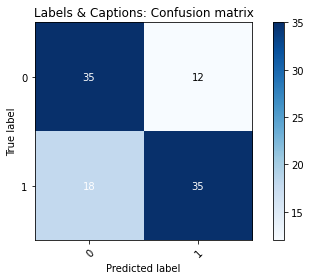

In [ ]:
plot_confusion_matrix(y_true = y_test, 
                      y_pred = y_pred, classes = np.unique(y_test),
                      title = 'Labels & Captions: Confusion matrix')

## Task C: Topic Modeling (LDA)

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import re


In [ ]:
ig_post_labeled.head()

,post_url,comment_num,like_num,post_caption,image_url,labels,like_percent,comment_percent,engagement_score,engagement_binary_class,labels_processed
0,https://www.instagram.com/p/CHYOgoNLjwD/,157,24098,Photo by @erintrieb / On Election Day I set up...,https://scontent-iad3-1.cdninstagram.com/v/t51...,"['Hair', 'Face', 'White', 'Black', 'Hairstyle'...",0.014033,0.003340,0.007617,0,hair face white black hairstyle shoulder head ...
1,https://www.instagram.com/p/CHXl8P8gT0f/,455,83621,Photo by @tasneemalsultan / A Saudi woman sits...,https://scontent-iad3-1.cdninstagram.com/v/t51...,"['Room', 'Textile', 'Tradition', 'Bazaar', 'Fl...",0.048695,0.009678,0.025285,0,room textile tradition bazaar flooring interio...
2,https://www.instagram.com/p/CHXXmNpAhHV/,431,184808,Photo by Keith Ladzinski @ladzinski / A kiss o...,https://scontent-iad3-1.cdninstagram.com/v/t51...,"['Mountainous landforms', 'Mountain', 'Sky', '...",0.107620,0.009168,0.048549,0,mountainous landforms mountain sky mountain ra...
3,https://www.instagram.com/p/CHXKiRnAshz/,511,106213,Photo by @dina_litovsky / Most people don’t as...,https://scontent-iad3-1.cdninstagram.com/v/t51...,"['Motor vehicle', 'Vehicle', 'Mode of transpor...",0.061851,0.010870,0.031262,0,motor vehicle vehicle mode of transport transp...
4,https://www.instagram.com/p/CHWudbnoMhb/,554,162146,Photo by @paoloverzone / Fluorescing a ghostly...,https://scontent-iad3-1.cdninstagram.com/v/t51...,"['Water', 'Blue', 'Liquid', 'Aqua', 'Transpare...",0.094423,0.011784,0.044840,0,water blue liquid aqua transparent material tu...


In [ ]:
# Remove punctuation

ig_post_labeled['labels_processed'] = ig_post_labeled['labels'].map(lambda x: x.replace("[", "").replace("]", "").replace(",", "").replace("'", "").lower())
ig_post_labeled['labels_processed'].head()

0    hair face white black hairstyle shoulder head ...
1    room textile tradition bazaar flooring interio...
2    mountainous landforms mountain sky mountain ra...
3    motor vehicle vehicle mode of transport transp...
4    water blue liquid aqua transparent material tu...
Name: labels_processed, dtype: object

In [ ]:
num_topics = 4

image_labels = ig_post_labeled['labels_processed']
count_vectorizer = CountVectorizer(stop_words='english')
lda_data = count_vectorizer.fit_transform(image_labels)
# Create and fit the LDA model
lda = LDA(n_components=num_topics, n_jobs=-1)
lda.fit(lda_data)
#lda.components_[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=4, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [ ]:
#lda.components_[0]

In [ ]:
#count_vectorizer.get_feature_names()

In [ ]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, 10)
#'Mountain','Citylife','Nature','Wildlife'

Topics found via LDA:

Topic #0:
mountain mountainous landforms sky rock range landscape dog military wilderness

Topic #1:
photography vehicle white monochrome black people event street fun art

Topic #2:
sky phenomenon plant tree natural water landscape cloud nature sea

Topic #3:
wildlife animal terrestrial mammal vertebrate bear snout ice grass bird


In [ ]:
#Output1 - A file showing which words load on which topics, 
words = count_vectorizer.get_feature_names()
topic0 = lda.components_[0]
topic1 = lda.components_[1]
topic2 = lda.components_[2]
topic3 = lda.components_[3]
d = {'words': words,
     'Mountain': topic0,
     'Citylife': topic1,
     'Nature': topic2,
     'Wildlife': topic3}
output1 = pd.DataFrame(d)
output1.head(10)


,words,Mountain,Citylife,Nature,Wildlife
0,abaya,2.246536,0.253391,0.250027,0.250045
1,abdomen,1.249827,0.250051,0.250049,0.250073
2,abseiling,0.250090,0.273834,1.226006,0.250070
3,academic,1.234543,0.265376,0.250031,0.250050
4,accessory,0.311647,4.255936,0.250048,2.182369
5,accipitridae,0.250031,0.250016,0.250015,1.249938
6,accipitriformes,0.255403,0.250018,0.250017,3.244562
7,acrobatic,0.351668,1.148223,0.250050,0.250059
8,adaptation,2.185888,15.169724,10.398897,12.245491
9,adventure,1.030553,2.635481,4.266906,1.067059


In [ ]:
output1.to_csv('TaskC_file1.csv', index=False)

In [ ]:
weights=lda.transform(lda_data)
topic_weights=pd.DataFrame(weights).rename(columns={0:'mountain', 1: 'city life', 2: 'nature', 3:'wildlife'})

In [ ]:
topic_weights.head(10)

,mountain,city life,nature,wildlife
0,0.020842,0.269554,0.020838,0.688767
1,0.025029,0.538959,0.025097,0.410916
2,0.941860,0.019288,0.019500,0.019352
3,0.019253,0.942270,0.019241,0.019236
4,0.017966,0.018183,0.945898,0.017952
5,0.019244,0.021024,0.019271,0.940461
6,0.023086,0.931337,0.022781,0.022795
7,0.581655,0.019533,0.020050,0.378762
8,0.021638,0.024305,0.932491,0.021567
9,0.031932,0.031263,0.031927,0.904877


In [ ]:
test_ig = ig_post_labeled.reset_index(drop=False)
test_topics = topic_weights.reset_index(drop=False)
post_weights = test_ig.merge(test_topics, on='index', how='inner')
post_weights.head()

,index,post_url,comment_num,like_num,post_caption,image_url,labels,like_percent,comment_percent,engagement_score,engagement_binary_class,labels_processed,mountain,city life,nature,wildlife
0,0,https://www.instagram.com/p/CHYOgoNLjwD/,157,24098,Photo by @erintrieb / On Election Day I set up...,https://scontent-iad3-1.cdninstagram.com/v/t51...,"['Hair', 'Face', 'White', 'Black', 'Hairstyle'...",0.014033,0.003340,0.007617,0,hair face white black hairstyle shoulder head ...,0.020842,0.269554,0.020838,0.688767
1,1,https://www.instagram.com/p/CHXl8P8gT0f/,455,83621,Photo by @tasneemalsultan / A Saudi woman sits...,https://scontent-iad3-1.cdninstagram.com/v/t51...,"['Room', 'Textile', 'Tradition', 'Bazaar', 'Fl...",0.048695,0.009678,0.025285,0,room textile tradition bazaar flooring interio...,0.025029,0.538959,0.025097,0.410916
2,2,https://www.instagram.com/p/CHXXmNpAhHV/,431,184808,Photo by Keith Ladzinski @ladzinski / A kiss o...,https://scontent-iad3-1.cdninstagram.com/v/t51...,"['Mountainous landforms', 'Mountain', 'Sky', '...",0.107620,0.009168,0.048549,0,mountainous landforms mountain sky mountain ra...,0.941860,0.019288,0.019500,0.019352
3,3,https://www.instagram.com/p/CHXKiRnAshz/,511,106213,Photo by @dina_litovsky / Most people don’t as...,https://scontent-iad3-1.cdninstagram.com/v/t51...,"['Motor vehicle', 'Vehicle', 'Mode of transpor...",0.061851,0.010870,0.031262,0,motor vehicle vehicle mode of transport transp...,0.019253,0.942270,0.019241,0.019236
4,4,https://www.instagram.com/p/CHWudbnoMhb/,554,162146,Photo by @paoloverzone / Fluorescing a ghostly...,https://scontent-iad3-1.cdninstagram.com/v/t51...,"['Water', 'Blue', 'Liquid', 'Aqua', 'Transpare...",0.094423,0.011784,0.044840,0,water blue liquid aqua transparent material tu...,0.017966,0.018183,0.945898,0.017952


In [ ]:
post_weights=post_weights.sort_values(by=['engagement_score'])
q1=np.percentile(post_weights['engagement_score'], 25)
q3=np.percentile(post_weights ['engagement_score'], 75)
#average topic scores for low and high engagement quartile
pd.DataFrame({'Topic':['Mountain','Citylife','Nature', 'Wildlife'],
              'Low_engagement':post_weights[post_weights['engagement_score']<=q1]\
              [post_weights.columns[-num_topics:]].mean(),\
              'High_engagement':post_weights[post_weights['engagement_score']>=q3][post_weights.columns[-num_topics:]].mean()})
#rows = topic name

,Topic,Low_engagement,High_engagement
mountain,Mountain,0.074132,0.177033
city life,Citylife,0.520110,0.185169
nature,Nature,0.237117,0.373017
wildlife,Wildlife,0.168641,0.264781
